In [1]:
#lets start with some imports

#Py-ART, simply the best sowftware around.. Give those guys a grant
import pyart

#Boto3 is the AWS SDK
import boto3

#botocore contains core configuration utilities for boto2 and boto3
from botocore.handlers import disable_signing

#Tempory files in Python.. A very useful module
import tempfile

#datetime modules.. very handy!
from datetime import datetime

#timezone info
import pytz

#plotting
from matplotlib import pyplot as plt

#plotting on a maop
import cartopy

import xarray as xr

%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/scollis/anaconda3/envs/pyart-2018/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def find_my_key(radar_name, desired_datetime):
    """
    Find the key in Amazon s3 corresponding to a particular radar site and 
    datetime
    
    Parameters
    ----------
    radar_name : str
        Four letter radar name
    desired_datetime : datetime
        The date time desired
    Returns
    -------
    my_key : string
        string matching the key for the radar file on AWS s3
    """
    
    bucket = "noaa-nexrad-level2"
    # Create a s3 "client"
    s3 = boto3.resource('s3')
    # Set it to unsigned 
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    target_string = datetime.strftime(desired_datetime, '%Y/%m/%d/'+radar_name)
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix=target_string)]
    my_list_of_datetimes = []
    for obj in aws_radar.objects.filter(Prefix=target_string):
        try:
            my_list_of_datetimes.append(datetime.strptime(obj.key[20:35], '%Y%m%d_%H%M%S'))
        except ValueError:
            pass #usually a tar file left in the bucket
    my_nearest = nearest(my_list_of_datetimes, desired_datetime)
    my_key = my_list_of_keys[my_list_of_datetimes.index(my_nearest)]
    return my_key

def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))


In [7]:
# So we start with bucket neame
bucket = "noaa-nexrad-level2"
# Create a s3 "client"
s3 = boto3.resource('s3')
# Set it to unsigned 
s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)

#So now we connect to the bucket with the radar data
aws_radar = s3.Bucket(bucket)
my_key = find_my_key('KVNX', datetime(2011,5,20,11,0))


In [8]:

#create a temporary named file
localfile = tempfile.NamedTemporaryFile()

#fetch the data from AWS S3
aws_radar.download_file(my_key, localfile.name)

#read that file into Py-ART!
radar = pyart.io.read(localfile.name)

In [11]:
rlat = radar.latitude['data'][0]
rlon = radar.longitude['data'][0]
sweep = 0

#Get the date at the start of collection
index_at_start = radar.sweep_start_ray_index['data'][sweep]
time_at_start_of_radar = pyart.io.cfradial.netCDF4.num2date(radar.time['data'][index_at_start], 
                                  radar.time['units'])

#make a nice time stamp
pacific = pytz.timezone('US/Central')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
print(fancy_date_string)

Friday May 20 at 05:58 AM CDT


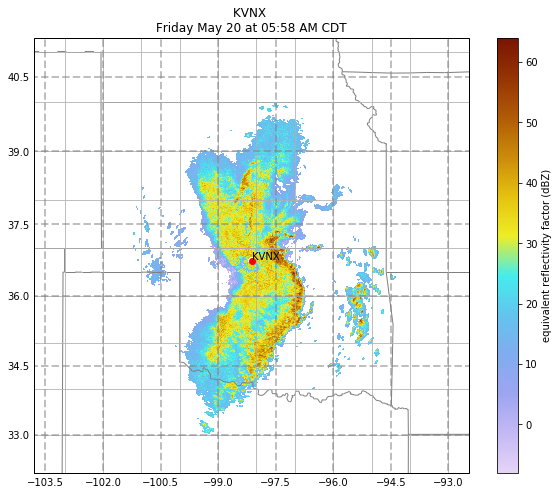

In [14]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplayCartopy(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'KVNX \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'reflectivity', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=-8, vmax=64)

# Mark the radar
display.plot_point(lon_0, lat_0, label_text='KVNX')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

In [16]:
xlocalfile = tempfile.NamedTemporaryFile()

#Write to Py-ART
pyart.io.write_cfradial(xlocalfile.name, radar)

#Read to X-array
xradar = xr.open_dataset(xlocalfile.name)

In [17]:
xradar.variables

Frozen(OrderedDict([('time', <xarray.IndexVariable 'time' (time: 8280)>
array(['2011-05-20T10:58:09.724999999', '2011-05-20T10:58:09.750000000',
       '2011-05-20T10:58:09.771999999', ..., '2011-05-20T11:02:20.167000000',
       '2011-05-20T11:02:20.201000000', '2011-05-20T11:02:20.235000000'],
      dtype='datetime64[ns]')
Attributes:
    long_name:      time_in_seconds_since_volume_start
    standard_name:  time
    comment:        Coordinate variable for time. Time at the center of each ...), ('range', <xarray.IndexVariable 'range' (range: 1832)>
array([  2125.,   2375.,   2625., ..., 459375., 459625., 459875.],
      dtype=float32)
Attributes:
    long_name:                       range_to_measurement_volume
    units:                           meters
    standard_name:                   projection_range_coordinate
    axis:                            radial_range_coordinate
    spacing_is_constant:             true
    comment:                         Coordinate variable for range

In [18]:
xradar.reflectivity.mean()

<xarray.DataArray 'reflectivity' ()>
array(26.718504)